In [7]:
#Import all the files to be shared among all notebooks 
import utils
import preprocessing
import data_visualization
import feature_engineering
import ML_algorithms
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df = utils.get_dataset()

In [3]:
df = feature_engineering.drop_useless_columns(df)

In [4]:
df = preprocessing.to_dtype_object(df)

In [5]:
df = preprocessing.encode_days_as_costumer(df)

In [6]:
df = preprocessing.impute_income_KNN(df)

In [23]:
df = preprocessing.outlier_IQR(df, ["Year_Birth","Income"])

Removing outliers using the IQR method with 2 quartiles would lead to a change of data size:  0.0


In [10]:
# 1) obtain the observed contingency table
feature, target = "Education", "Response"
df_rec = df[[feature, target]]

obs_cont_tab = pd.crosstab(df_rec[feature], df_rec[target], margins = True)
obs_cont_tab 

Response,0,1,All
Education,,,
2n Cycle,181,22,203
Basic,52,2,54
Graduation,975,152,1127
Master,313,57,370
PhD,385,101,486
All,1906,334,2240


In [11]:
# 2) calculate the expected contingency table, assuming there is no association
exp_cont_tab = obs_cont_tab.copy()

n_r = exp_cont_tab.iloc[:-1, -1]
N = exp_cont_tab.iloc[-1, -1]
for c in range(obs_cont_tab.shape[1]-1):
    n_c = exp_cont_tab.iloc[-1, c]
    exp_cont_tab.iloc[:-1, c] = np.divide(np.multiply(n_c, n_r), N)

# visually compare both tables, side by side
pd.concat([obs_cont_tab.iloc[:, :-1], exp_cont_tab], axis=1)

Response,0,1,0,1,All
Education,,,,,
2n Cycle,181,22,172.731250,30.268750,203
Basic,52,2,45.948214,8.051786,54
Graduation,975,152,958.956250,168.043750,1127
Master,313,57,314.830357,55.169643,370
PhD,385,101,413.533929,72.466071,486
All,1906,334,1906.000000,334.000000,2240


In [12]:
# 3) compute the test statistic as measure of dissimilarity between the expected and observed tables
obs, exp = [], []
for c in range(obs_cont_tab.shape[1]-1):
    exp.append(exp_cont_tab.iloc[:-1, c].values)
    obs.append(obs_cont_tab.iloc[:-1, c].values)
    
chi_squared_stat = np.sum(np.divide(np.power(np.subtract(obs, exp), 2), exp))
print('Chi-squared test statistic: {0:.2f}'.format(chi_squared_stat))

Chi-squared test statistic: 23.08


In [14]:
from scipy import stats
chisq = stats.chi2_contingency(obs_cont_tab.iloc[:-1, [0, 1]].values)[0:2]
print("Test statistic: {0:.2f}, p-value: {1:.4f}".format(chisq[0], chisq[1]))

Test statistic: 23.08, p-value: 0.0001


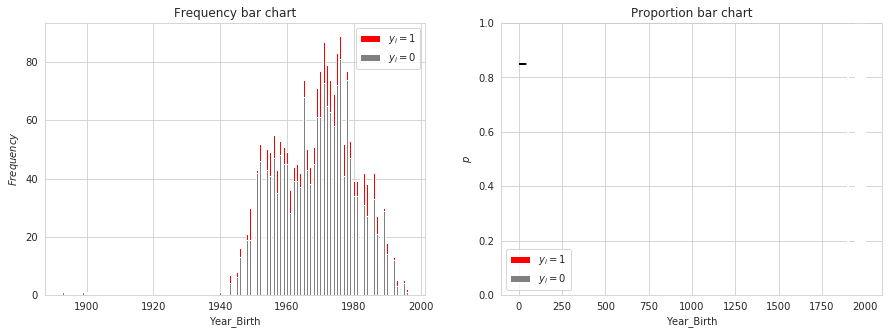

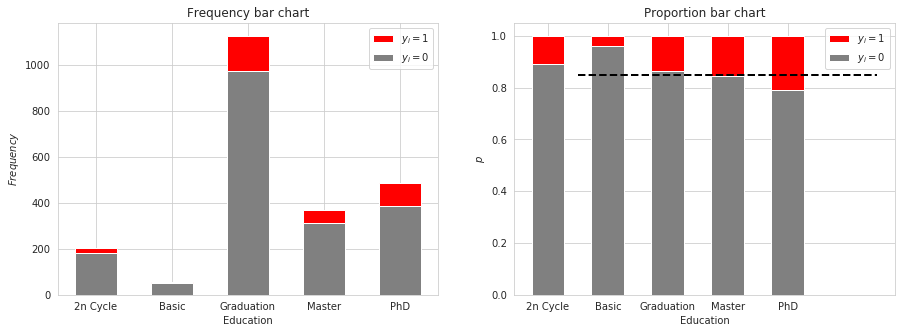

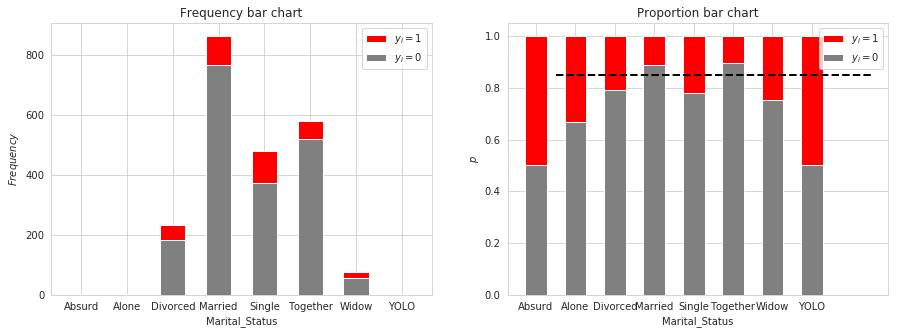

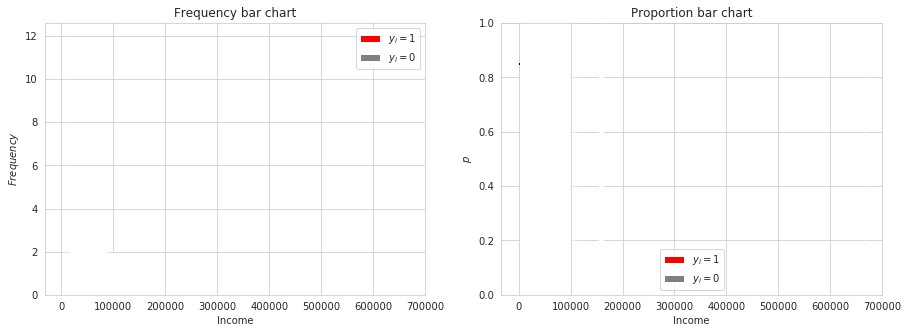

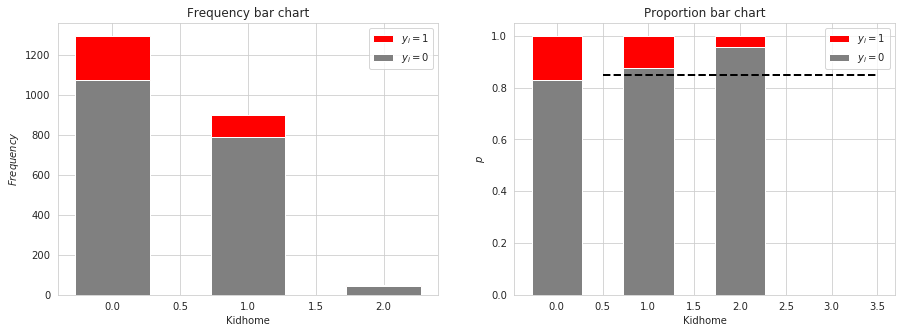

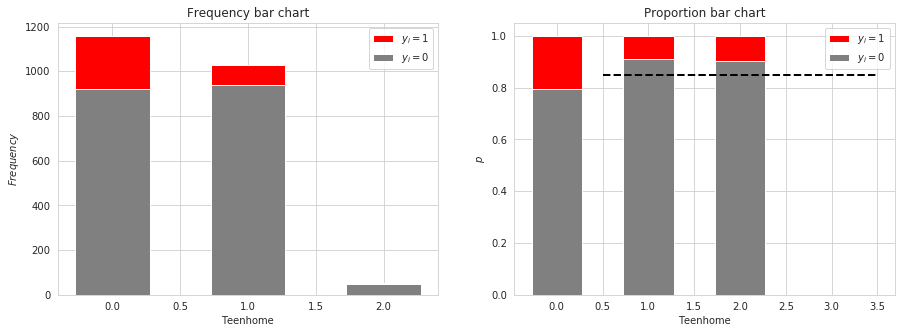

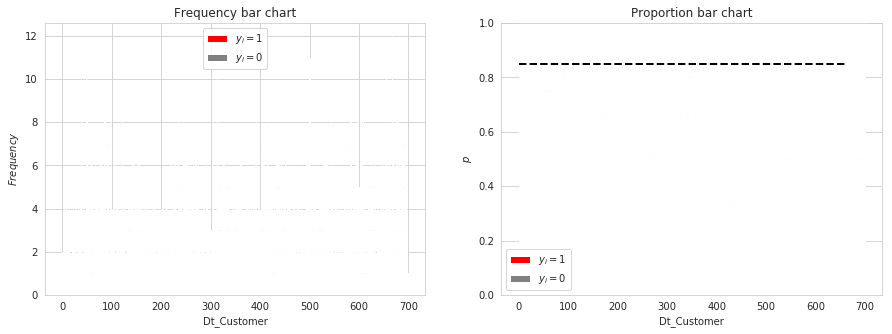

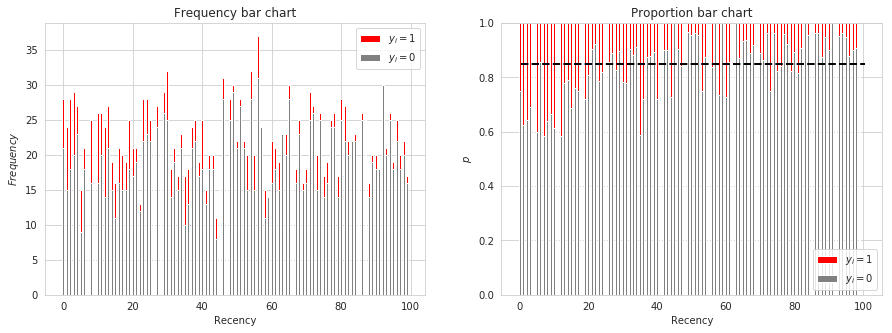

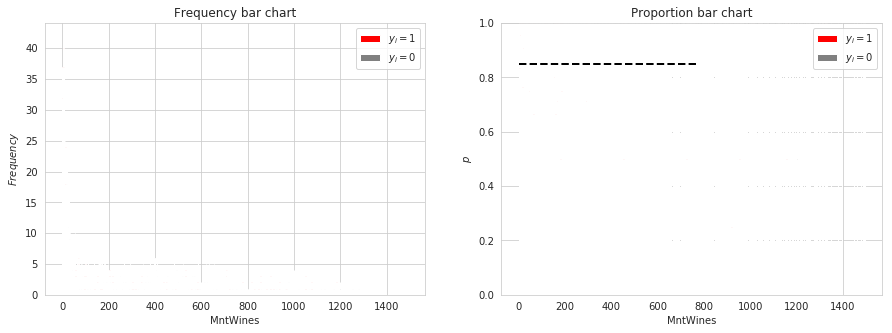

KeyboardInterrupt: 

In [18]:
from sklearn.preprocessing import KBinsDiscretizer

def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 
                 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 
                 0.55, bottom=cont_tab.iloc[:-1, 0], color="red")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
    
    mean_target = 1-df[target].mean()
    
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="red")
    plt.plot([.5, len(categories)+.5], [mean_target, mean_target],'--', lw=2, color="black")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()

for i in df:
    bar_charts_categorical(df, i, "Response")

In [24]:
from sklearn.preprocessing import KBinsDiscretizer

# 1) equal width binning of a continuous feature
feature, n_bins = "Income", 10
bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
mnt_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
mnt_bin = pd.Series(mnt_bin[:, 0], index=df.index)
print("Parameters of discretizer: ", bindisc.get_params())
print("Thresholds for {} bins of {}: ".format(n_bins, feature), bindisc.bin_edges_)

# 2) generate a contingency table, required for the Chi-Squared test
obs_cont_tab = pd.crosstab(mnt_bin, df[target])

# 3) compute Chi-Squared test for binned feature
chisq=stats.chi2_contingency(obs_cont_tab.values)[0:2]
print("Test statistic: {0:0.2f}, p-value: {1:0.2f}".format(chisq[0], chisq[1]))

Parameters of discretizer:  {'encode': 'ordinal', 'n_bins': 10, 'strategy': 'uniform'}
Thresholds for 10 bins of Income:  [array([  1730. ,  12930.4,  24130.8,  35331.2,  46531.6,  57732. ,
        68932.4,  80132.8,  91333.2, 102533.6, 113734. ])]
Test statistic: 158.43, p-value: 0.00


In [28]:
# 1) equal width binning of a continuous feature
feature, n_bins = "Income", 10
bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
mnt_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
mnt_bin = pd.Series(mnt_bin[:, 0], index=df.index)
print("Parameters of discretizer: ", bindisc.get_params())
print("Thresholds for {} bins of {}: ".format(n_bins, feature), bindisc.bin_edges_)

# 2) generate a contingency table, required for the Chi-Squared test
obs_cont_tab = pd.crosstab(mnt_bin, df[target])

# 3) compute Chi-Squared test for binned feature
chisq=stats.chi2_contingency(obs_cont_tab.values)[0:2]
print("Test statistic: {0:0.2f}, p-value: {1:0.2f}".format(chisq[0], chisq[1]))

Parameters of discretizer:  {'encode': 'ordinal', 'n_bins': 10, 'strategy': 'quantile'}
Thresholds for 10 bins of Income:  [array([  1730. ,  23894. ,  31803.6,  38004.2,  44362.2,  51141. ,
        58107.6,  65056.2,  71446.8,  79542.6, 113734. ])]
Test statistic: 141.86, p-value: 0.00


In [ ]:
def impute_income_KNN(df):
    dataframe = df.copy()
    dataframe_c = dataframe.dropna().select_dtypes(include=["number"]).drop(["Response"], axis = 1)
    dataframe_i = dataframe[pd.isnull(dataframe).any(axis=1)].select_dtypes(include=["number"]).drop(["Response"], axis = 1)
    clf = KNeighborsClassifier(3, weights='uniform', metric = 'euclidean')
    trained_model = clf.fit(dataframe_c.drop(["Income"],axis=1), dataframe_c.loc[:,'Income'])
    imputed_values = trained_model.predict(dataframe_i.drop(["Income"], axis=1))
    #print(imputed_values)
    dataframe_i["Income"] = imputed_values
    dataframe_new = pd.concat([df_i, df_c])
    dataframe_new = dataframe_new.sort_index()
    dataframe["Income"] = dataframe_new["Income"]
    return dataframe

In [ ]:
def outlier_IQR(df, columns=["Year_Birth","Income"]):
    """
    outlier deletetion using the IQR, you can choose the variables you want to delete the outliers for by selecting the columns. The default is Year_Birth & Income. Also you can change the quantile values.
    """
    dataframe = df.copy()
    Q1 = dataframe[columns].quantile(0.25)
    Q3 = dataframe[columns].quantile(0.75)
    IQR = Q3 - Q1
    #print(IQR)
    dataframe[columns] = dataframe[columns][~((dataframe < (Q1 - 2 * IQR)) |(dataframe > (Q3 + 2 * IQR))).any(axis=1)]
    dataframe = dataframe.dropna()
    print('Removing outliers using the IQR method with 2 quartiles would lead to a change of data size: ',(dataframe.shape[0] -df.shape[0]) /df.shape[0])
    return dataframe

In [ ]:
def outlier_ZSCORE(df, columns=["Year_Birth", "Income"], threshold=3):
    """
    outlier deletion using the Zscore, you can choose which columns you want to apply it on and you can choose which threshold you want to use.
    """
    dataframe = df.copy()
    columns_zscore = []
    for i in dataframe[columns]:
        i_zscore = i + "_zscore"
        columns_zscore.append(str(i_zscore))
        
        dataframe[i_zscore] = (dataframe[i] - dataframe[i].mean())/df[i].std(ddof=0)
    for i in dataframe[columns_zscore]:
        dataframe = dataframe[(dataframe[i] < threshold) & (dataframe[i] > -threshold)]
    dataframe = dataframe.drop(columns_zscore, axis=1)
    print('Removing outliers using the ZSCORES method with a threshold of 3 would lead to a change of data size: ',(dataframe.shape[0] -df.shape[0]) /df.shape[0])
    return dataframe

In [ ]:
outlier_IQR(df,["Year_Birth","Income","MntSweetProducts","MntMeatProducts","MntGoldProds"]).head()

outlier_ZSCORE(df,["Year_Birth","Income","MntSweetProducts","MntMeatProducts","MntGoldProds"]).head()